# Выбранная методология в отборе переменных для модели

После перебора данных оставила данные, которые получила из исходных данных, 
без добавления дополнительных данных из вне.
1. Это количество видов разных кухонь, которые подаются в ресторане.
2. Число откликов. Оказалось показательным, чем ниже рейтинг, тем больше отзывов. 
3. Время между откликами в днях.
4. Пересчитанный по своему рейтинг: этот показатель универсально сочетает в себе и размер города (по количеству жителей, туристов и ресторанов), а также показывает распределение предпочтений посетителей. Чтобы этот показатель сделать пригодным, я как бы нормирую следующим образом: беру max от Ranking - это по сути и есть размер, считаю этот мах за 100%, а остальные места внутри города распределяю между 0 и 100% пропорционально занятым местам (Ranking). Получается некий нормированный универсальный показатель, который можно использовать.
5. Уровень MAE около 0,23

# Загрузка Pandas и очистка данных

In [1]:
import pandas as pd
import datetime
from datetime import datetime, timedelta
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели


RANDOM_SEED = 42

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [3]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
# скачали основную базу
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [5]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [6]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [8]:
# добавляю колонку - число разных кухонь подаваемых в ресторане - это одна из значимых переменных для модели
df['kuhn']=df['Cuisine Style'].apply(lambda x: 1 if pd.isna(x)==True else len(x[1:-1].split(', ')) )

In [9]:
# подсчет ресторанов по количеству подаваемых кухонь для справки, чтобы убедиться, что разброс очень большой
df['kuhn'].value_counts()

1     20744
2      7794
3      6638
4      5948
5      4482
6      2611
7      1294
8       363
9        93
10       26
11        4
21        1
15        1
13        1
Name: kuhn, dtype: int64

In [10]:
# работаем с колонкой Reviews. В ней есть данные, которые нужно почистить
df['Reviews'].fillna('', inplace=True)

In [11]:
# поиск дат комментариев и работа с датами, определение таймдельта
def time_one(x):
    b=x[1:-1].split("[")[-1][1:11]
    d1=datetime.strptime(b,'%m/%d/%Y')
    return d1

def time_end(x):
    c=x[1:-1][-12:-2]
    d2=datetime.strptime(c,'%m/%d/%Y')
    return d2

df['tim_1']=df['Reviews'].apply(lambda x: 0 if len(x)<10 else time_one(x))
df['tim_2']=df['Reviews'].apply(lambda x: 0 if len(x)<10 else time_end(x))
df['delta']=df['tim_1']-df['tim_2'] # в формате таймдельта
df['delta_1']=df['Ranking']

In [12]:
# преобразование таймдельты и запись в столбец delta_1 в виде числа (количество целых дней)
ll=len(df)
for i in range(ll):
    a=df.iloc[i,14]
    if a==0:
        df.iloc[i,15]=0
    else:
        df.iloc[i,15]=a/timedelta(1)

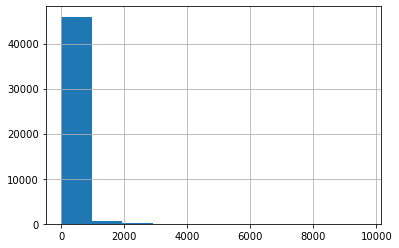

In [13]:
df['Number of Reviews'].hist()

In [14]:
# небольшая коррекция очень длинных сообщений
df['Number of Reviews']=df['Number of Reviews'].apply(lambda x: x if x<1200 else 1200)

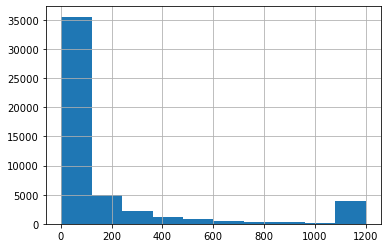

In [15]:
# распределение числа отзывов
df['Number of Reviews'].hist()

In [16]:
# разные попытки превратить цену в категориальную переменную и потом ее использовать
# ничего интересного не дали, поэтому эти данные убираю 
df=df.drop(['Price Range'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Number of Reviews  50000 non-null  float64
 5   Reviews            50000 non-null  object 
 6   URL_TA             50000 non-null  object 
 7   ID_TA              50000 non-null  object 
 8   sample             50000 non-null  int64  
 9   Rating             50000 non-null  float64
 10  kuhn               50000 non-null  int64  
 11  tim_1              50000 non-null  object 
 12  tim_2              50000 non-null  object 
 13  delta              50000 non-null  object 
 14  delta_1            50000 non-null  float64
dtypes: float64(4), int64(2), object(9)
memory usage: 5.7+ MB


In [17]:
# работаю с городами и полем Ranking - 
# собираю словарь, где есть название города и максимальное значение Ranking для него
# это некая условная "линейка размерности" для оценки значения Ranking

city = set(df.City)
city
dict = {}
for m in city:
    n = str(m)
    max_ = df[df.City == m]['Ranking'].max()
    dict.setdefault(m,max_)

In [18]:
# города и номер самого последнего в рейтинге ресторана - линейка для дальнейшего нормирования

dict

{'Brussels': 3006.0,
 'Lyon': 2666.0,
 'Ljubljana': 468.0,
 'Oslo': 1137.0,
 'Budapest': 2440.0,
 'Milan': 6275.0,
 'Prague': 4188.0,
 'Athens': 1787.0,
 'London': 16444.0,
 'Luxembourg': 621.0,
 'Dublin': 1960.0,
 'Copenhagen': 1964.0,
 'Madrid': 8809.0,
 'Stockholm': 2464.0,
 'Hamburg': 2737.0,
 'Oporto': 1484.0,
 'Barcelona': 7796.0,
 'Munich': 2763.0,
 'Warsaw': 2154.0,
 'Krakow': 1244.0,
 'Geneva': 1413.0,
 'Rome': 5948.0,
 'Lisbon': 3717.0,
 'Vienna': 3444.0,
 'Berlin': 6372.0,
 'Edinburgh': 1766.0,
 'Bratislava': 889.0,
 'Paris': 13986.0,
 'Amsterdam': 3254.0,
 'Zurich': 1601.0,
 'Helsinki': 1141.0}

In [19]:
# новый признак Rank2 по работе с рейтингами - пересчет рейтинга исходя из того, 
# какое он место занимает среди ресторанов своего города

df['City1'] = df['City']
df['City1'] = df['City1'].replace(to_replace = dict)
df.head()
df['Rank2'] = round(df['Ranking']/df['City1']*100,1)
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,kuhn,tim_1,tim_2,delta,delta_1,City1,Rank2
0,id_0,Paris,"['Bar', 'Pub']",12963.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,2,0,0,0,0.0,13986.0,92.7
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,5,2017-12-05 00:00:00,2017-10-29 00:00:00,"37 days, 0:00:00",37.0,1141.0,9.3
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,1,2017-12-28 00:00:00,2017-12-06 00:00:00,"22 days, 0:00:00",22.0,1766.0,45.9
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,5,2017-12-06 00:00:00,2017-11-22 00:00:00,"14 days, 0:00:00",14.0,16444.0,10.1
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,6,2018-02-08 00:00:00,2018-01-24 00:00:00,"15 days, 0:00:00",15.0,889.0,4.2


In [20]:
df[df.City=='Athens'].groupby(['Rating'])['Ranking'].mean()

Rating
0.0     876.418919
1.0    1787.000000
1.5    1771.000000
2.0    1767.000000
2.5    1754.750000
3.0    1641.777778
3.5    1299.830986
4.0     901.725888
4.5     652.568465
5.0     886.838710
Name: Ranking, dtype: float64

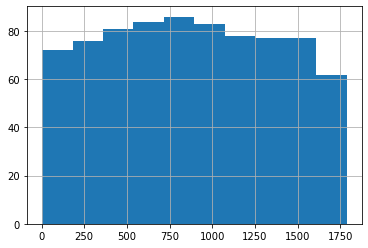

In [21]:
# выборочно смотрим, как распределены рестораны внутри Ranking - распределение хорошее
# здесь распределение на примере города Афины

df[df.City=='Athens']['Ranking'].hist()

In [22]:
# аналогично по городу Парижу

df[df.City=='Paris'].groupby(['Rating'])['Ranking'].mean()

Rating
0.0     6960.980182
1.0    13945.916667
1.5    13851.222222
2.0    13683.711864
2.5    13341.853659
3.0    12224.257075
3.5     8714.340045
4.0     5859.059870
4.5     4504.664898
5.0     6071.510029
Name: Ranking, dtype: float64

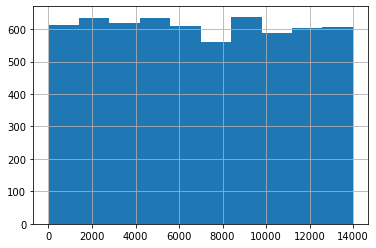

In [23]:
df[df.City=='Paris']['Ranking'].hist()

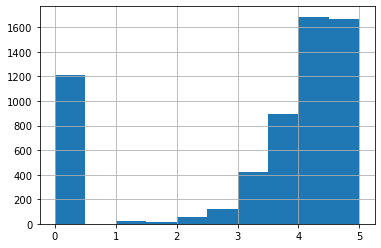

In [24]:
# распределение оценки Rating в городе Парижа -
# распределение понятное, т.к. в данных df_test в столбце стоит 0

df[df.City=='Paris']['Rating'].hist()

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [25]:
df_train=df.query('sample == 1').drop(['sample'], axis=1)
df_test=df.query('sample == 0').drop(['sample'], axis=1)

In [26]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)

X = df_train[['Rank2','Number of Reviews','delta_1','kuhn']]
y = df_train['Rating']

In [27]:
X

,Rank2,Number of Reviews,delta_1,kuhn
10000,39.8,194.0,41.0,3
10001,62.4,10.0,382.0,1
10002,2.1,688.0,2.0,7
10003,54.3,3.0,0.0,1
10004,22.5,84.0,272.0,3
...,...,...,...,...
49995,8.0,79.0,34.0,4
49996,45.3,542.0,9.0,5
49997,67.0,4.0,3127.0,2
49998,29.8,70.0,23.0,5


In [28]:
X.corr()

,Rank2,Number of Reviews,delta_1,kuhn
Rank2,1.000000,-0.127304,0.099745,-0.541132
Number of Reviews,-0.127304,1.000000,-0.158222,0.155744
delta_1,0.099745,-0.158222,1.000000,-0.124601
kuhn,-0.541132,0.155744,-0.124601,1.000000


In [29]:
# Таблица корреляций между показателями
X.corr()

,Rank2,Number of Reviews,delta_1,kuhn
Rank2,1.000000,-0.127304,0.099745,-0.541132
Number of Reviews,-0.127304,1.000000,-0.158222,0.155744
delta_1,0.099745,-0.158222,1.000000,-0.124601
kuhn,-0.541132,0.155744,-0.124601,1.000000


# Создаём, обучаем и тестируем модель

In [30]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

In [31]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [32]:
y_pred

array([4.515, 3.62 , 4.37 , ..., 4.405, 3.985, 4.515])

In [33]:
# округляем до 0,5
for i in range(len(y_pred)):
    y_pred[i] = round(y_pred[i] * 2) / 2

In [34]:
y_pred

array([4.5, 3.5, 4.5, ..., 4.5, 4. , 4.5])

In [35]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.23405


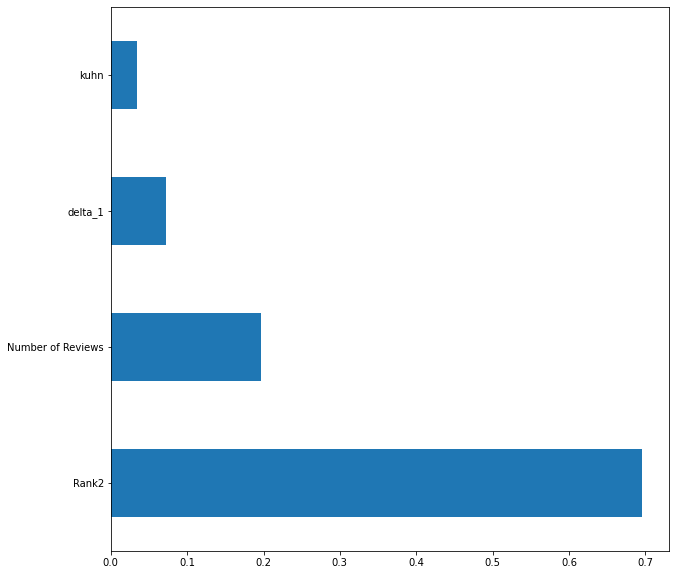

In [36]:
# визуализируем влияние параметров
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission

In [37]:
test_data=df_test[['Rank2','Number of Reviews','delta_1','kuhn']]
test_data

,Rank2,Number of Reviews,delta_1,kuhn
0,92.7,4.0,0.0,2
1,9.3,97.0,37.0,5
2,45.9,28.0,22.0,1
3,10.1,202.0,14.0,5
4,4.2,162.0,15.0,6
...,...,...,...,...
9995,26.6,28.0,122.0,4
9996,70.3,2.0,0.0,4
9997,88.6,2.0,0.0,1
9998,63.9,2.0,0.0,1


In [38]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [39]:
predict_submission = regr.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [40]:
predict_submission

array([3.47166667, 4.39      , 4.165     , ..., 3.06055952, 4.42185788,
       4.33333333])

In [41]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.471667
1,id_1,4.390000
2,id_2,4.165000
3,id_3,4.290000
4,id_4,4.500000
5,id_5,4.430000
6,id_6,1.880000
7,id_7,5.000000
8,id_8,4.494375
9,id_9,4.645000
